In [6]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import chirp

import toolkit

from matplotlib import interactive
interactive(True)
%matplotlib notebook

In [13]:
def import_roach_data():

    roach_files = glob.glob('ROACH/*.out')
    noise_files = []
    signal_files = []

    for file in roach_files:
        try:
            file.index('noise')
            noise_files.append(file)

        except ValueError:
            try:
                file.index('MHz')

                try:
                    file.index('7_8125MHz')

                except ValueError:
                    signal_files.append(file)
            
            except ValueError:
                pass

    noise_files.sort()
    signal_files.sort()

    noise_dict = {}
    for file in noise_files:
        with open(file) as f:
            file_content_raw = f.readlines()
            file_content_trimmed = [float(entry[:-1]) for entry in file_content_raw]
            file_array = np.array(file_content_trimmed,float)
            f.close()
        noise_dict[file[6:-4]] = file_array

    signal_dict = {}
    for file in signal_files:
        with open(file) as f:
            file_content_raw = f.readlines()
            file_content_trimmed = [float(entry[:-1]) for entry in file_content_raw]
            file_array = np.array(file_content_trimmed,float)
            f.close()
        signal_dict[file[6:-4]] = file_array

    return signal_dict, noise_dict

def noise_averager(noise_dict):
    
    noise_keys = tuple(noise_dict.keys())
    file_length = len(noise_dict[noise_keys[0]])
    noise_average = np.zeros(file_length)
    count = 0

    for key in noise_keys:
        noise_average += noise_dict[key]
        count += 1

    noise_average /= count

    return noise_average

def signal_cleaner(signal_dict,noise):
    
    clean_dict = {}
    signal_keys = tuple(signal_dict.keys())
    
    for key in signal_keys:
        if len(signal_dict[key]) == len(noise):
            clean_signal = signal_dict[key] - noise
            clean_dict[key] = clean_signal

    return clean_dict

def attenuation_signal_gen():
    
    fs = 800e6
    Npoint = 2048
    bin_width = fs/Npoint

    time = np.arange(0,0.05,1/fs)

    const_seq = (20,21.125,22.25,23.375,24.50,25.625,26.75,27.875,29)
    keylabels = (
        'Centred',
        '1/8 Offset',
        '2/8 Offset',
        '3/8 Offset',
        '4/8 Offset',
        '5/8 Offset',
        '6/8 Offset',
        '7/8 Offset',
        'Centred'
    )
    fft_dict = {}
    for c in const_seq:
        signal = np.sin(2*np.pi*bin_width*c*time)
        fft = np.fft.rfft(signal,n=Npoint)
        fft_dict[bin_width*c] = fft

    freqs = np.fft.rfftfreq(n=Npoint)
    keys = tuple(fft_dict.keys())

    plt.figure()

    for key in keys:
        keylable = str(key/1e6) + 'MHz'
        plt.plot(np.abs(fft_dict[key]),label=keylabels[keys.index(key)],marker='.',ls='--')
    plt.legend()
    plt.xlim(15,35)
    plt.title('Raw FFT Bin Offset Attenuation')
    plt.xlabel('Bin/Channel Number')
    plt.ylabel('Signal Strength (a.u.)')
    plt.savefig('ROACH/fft_synth.png')
   
def attenuation():
    
    roach_data_exists = os.path.isdir('ROACH')
    if roach_data_exists:
        signal_dict, noise_dict = import_roach_data()
        noise_average = noise_averager(noise_dict)
        signals_cleaned = signal_cleaner(signal_dict,noise_average)

        clean_keys = tuple(signals_cleaned.keys())
        freqs = np.linspace(0,400,2048)

        plt.figure()
        for key in clean_keys:
            plt.plot(freqs,np.abs(signals_cleaned[key]),label=key)
        plt.legend()
        plt.title('Frequency input of signals into ROACH board')
        plt.xlabel('Frequency (MHz)')
        plt.ylabel('Signal Strength (a.u.)')
        plt.xlim(30,55)
        plt.ylim(0,0.95e7)
        plt.show()

    elif not(roach_data_exists):
        print('ROACH data not detected; no data imported')

<IPython.core.display.Javascript object>


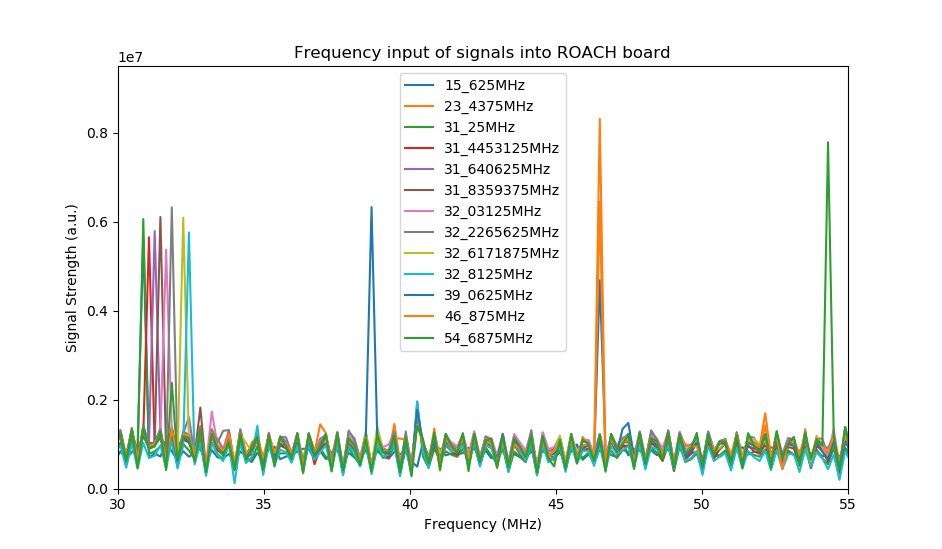

In [9]:
attenuation()

<IPython.core.display.Javascript object>


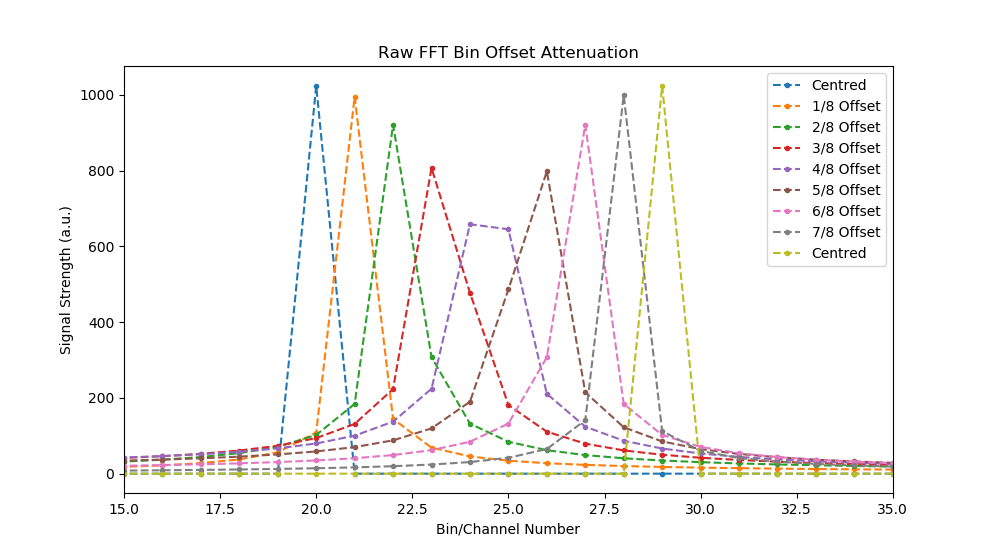

In [10]:
attenuation_signal_gen()